σ= 1.0
フィッシャー情報量:
I(p(x; μ)) = 0.5295116901
I(p_S(x; μ_S)) = 2.1180462837
I(p_T(x; μ_T)) = 2.1180462837
MI(p_S(x; μ_S),p_T(x; μ_T)) = 2.1180462837
スカラー曲率 R(p(x; μ)) = 0.6606712341
--------
σ= 2.0
フィッシャー情報量:
I(p(x; μ)) = 0.1941574663
I(p_S(x; μ_S)) = 4.8539371490
I(p_T(x; μ_T)) = 0.3033710718
MI(p_S(x; μ_S),p_T(x; μ_T)) = 1.2134842873
スカラー曲率 R(p(x; μ)) = 71.6755142212
--------
σ= 3.0
フィッシャー情報量:
I(p(x; μ)) = 0.1051237360
I(p_S(x; μ_S)) = 10.5123729706
I(p_T(x; μ_T)) = 0.1297823787
MI(p_S(x; μ_S),p_T(x; μ_T)) = 1.1680413485
スカラー曲率 R(p(x; μ)) = 248.7246398926
--------
σ= 4.0
フィッシャー情報量:
I(p(x; μ)) = 0.0574724004
I(p_S(x; μ_S)) = 16.6095237732
I(p_T(x; μ_T)) = 0.0648809522
MI(p_S(x; μ_S),p_T(x; μ_T)) = 1.0380952358
スカラー曲率 R(p(x; μ)) = 919.3612060547
--------
σ= 5.0
フィッシャー情報量:
I(p(x; μ)) = 0.0384274386
I(p_S(x; μ_S)) = 25.9769439697
I(p_T(x; μ_T)) = 0.0415631086
MI(p_S(x; μ_S),p_T(x; μ_T)) = 1.0390778780
スカラー曲率 R(p(x; μ)) = 2023.3944091797
--------


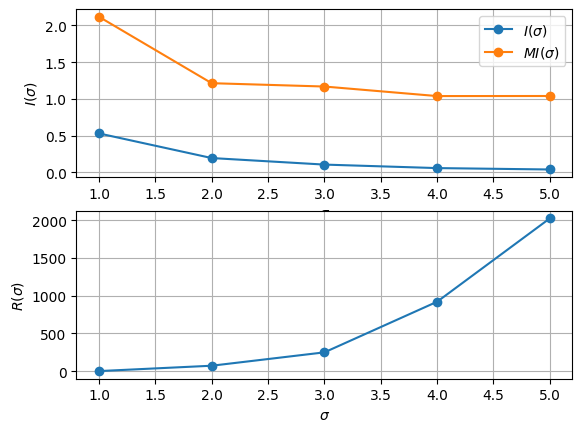

In [5]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

torch.manual_seed(seed=1)

# パラメータ設定
mu_S = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)  # ソース分布の平均
sigma_S = torch.tensor([1.0], dtype=torch.float32, requires_grad=True)   # ソース分布の標準偏差

I = []
R = []
C = []
MI = []
sigma_T_list = [1.0, 2.0, 3.0, 4.0, 5.0]  # 小数点を含む浮動小数点数にする
for i in sigma_T_list:
  mu_T = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)  # ターゲット分布の平均
  sigma_T = torch.tensor([i], dtype=torch.float32, requires_grad=True)   # ターゲット分布の標準偏差
  num_samples = 2000  # サンプリング数

  # ソース・ターゲットの正規分布
  p_S = dist.Normal(mu_S, sigma_S)
  p_T = dist.Normal(mu_T, sigma_T)

  # 正規化定数 Z(μ_S, μ_T) の計算
  sigma_P = torch.sqrt(sigma_S**2 + sigma_T**2)
  mu_P = (mu_S * sigma_T**2 + mu_T * sigma_S**2) / (sigma_S**2 + sigma_T**2)
  sigma_P.requires_grad_()
  mu_P.requires_grad_()
  p_P = dist.Normal(mu_P, sigma_P)

  # x を合成分布 p(x; μ) からサンプリング
  x_samples = p_P.sample((num_samples,))
  x_samples.requires_grad_()

  # 各分布の確率密度値を計算
  p_x_vals = torch.exp(p_P.log_prob(x_samples))
  p_S_vals = torch.exp(p_S.log_prob(x_samples))
  p_T_vals = torch.exp(p_T.log_prob(x_samples))

  # フィッシャー情報量の計算
  def fisher_information(p, x):
      grad_log_p = torch.autograd.grad(p.log_prob(x).sum(), x, create_graph=True)[0]
      return torch.mean(grad_log_p**2)
  
  # 相互フィッシャー情報量の計算
  def mutual_fisher_information(ps,pt, x):
      grad_log_ps = torch.autograd.grad(ps.log_prob(x).sum(), x, create_graph=True)[0]
      grad_log_pt = torch.autograd.grad(pt.log_prob(x).sum(), x, create_graph=True)[0]
      return torch.mean(grad_log_ps*grad_log_pt)

    
  I_pP = fisher_information(p_P, x_samples)
  I_pS = fisher_information(p_S, x_samples)
  I_pT = fisher_information(p_T, x_samples)
  I_pST=   mutual_fisher_information(p_S,p_T, x_samples)

  # スカラー曲率の計算
  def scalar_curvature(I_p, gamma):
      dI_dgamma = torch.autograd.grad(I_p, gamma, create_graph=True, retain_graph=True)[0]
      ddI_ddgamma = torch.autograd.grad(dI_dgamma, gamma, create_graph=True, retain_graph=True)[0]
      R = -1 / (I_p* I_p*2) * ddI_ddgamma + 3/(4*I_p*I_p*I_p)*(dI_dgamma / (2 * I_p))**2
      return R

  R_pP = scalar_curvature(I_pP, sigma_P)

  I.append(I_pP.item())
  MI.append(I_pST.item())
  R.append(R_pP.item())
  C.append(I_pP.item()-I_pS.item()-I_pT.item())

  # 結果表示
  print("σ=",i)
  print("フィッシャー情報量:")
  print(f"I(p(x; μ)) = {I_pP.item():.10f}")
  print(f"I(p_S(x; μ_S)) = {I_pS.item():.10f}")
  print(f"I(p_T(x; μ_T)) = {I_pT.item():.10f}")
  print(f"MI(p_S(x; μ_S),p_T(x; μ_T)) = {I_pST.item():.10f}")
  print(f"スカラー曲率 R(p(x; μ)) = {R_pP.item():.10f}")
  print("--------")

plt.figure()
plt.subplot(211)
plt.plot(sigma_T_list, I, "o-", label=r"$I(\sigma)$")
plt.plot(sigma_T_list, MI, "o-", label=r"$MI(\sigma)$")
plt.grid()
plt.legend()
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$I(\sigma)$")

plt.subplot(212)
plt.plot(sigma_T_list, R, "o-", label=r"$R(\theta)$")
plt.grid()
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$R(\sigma)$")
plt.show()

γ_T = 1.0
フィッシャー情報量: I(p_P) = 0.1269776523
I(p_S) = 0.4404639900, I(p_T) = 0.4404639900
MI(p_S(x; μ_S),p_T(x; μ_T)) = 0.4404639900
スカラー曲率: R(p_P) = 83.5843658447
--------
γ_T = 2.0
フィッシャー情報量: I(p_P) = 0.0564733148
I(p_S) = 0.3746707439, I(p_T) = 0.1215585992
MI(p_S(x; μ_S),p_T(x; μ_T)) = 0.2014117241
スカラー曲率: R(p_P) = 456.2084350586
--------
γ_T = 3.0
フィッシャー情報量: I(p_P) = 0.0314414985
I(p_S) = 0.3202978075, I(p_T) = 0.0548366047
MI(p_S(x; μ_S),p_T(x; μ_T)) = 0.1147727221
スカラー曲率: R(p_P) = 1515.5336914062
--------
γ_T = 4.0
フィッシャー情報量: I(p_P) = 0.0195227750
I(p_S) = 0.2815348208, I(p_T) = 0.0300811082
MI(p_S(x; μ_S),p_T(x; μ_T)) = 0.0729715973
スカラー曲率: R(p_P) = 3983.8903808594
--------
γ_T = 5.0
フィッシャー情報量: I(p_P) = 0.0136585962
I(p_S) = 0.2491257489, I(p_T) = 0.0195197426
MI(p_S(x; μ_S),p_T(x; μ_T)) = 0.0517148152
スカラー曲率: R(p_P) = 8184.5292968750
--------


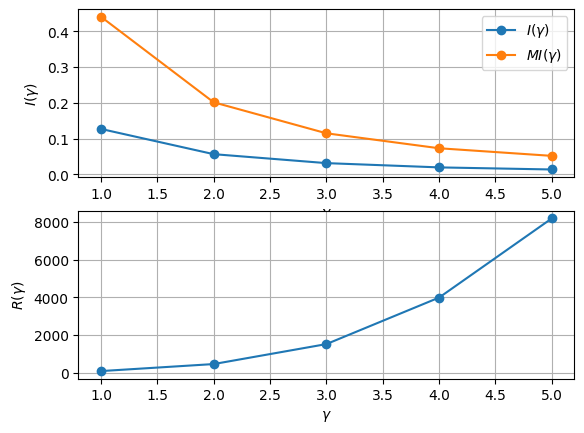

In [3]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

torch.manual_seed(1)

# パラメータ設定（Cauchy分布）
mu_S = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)  # ソース分布の位置パラメータ
gamma_S = torch.tensor([1.0], dtype=torch.float32, requires_grad=True)   # ソース分布のスケールパラメータ

I = []
R = []
C = []
MI = []
gamma_T_list = [1.0, 2.0, 3.0, 4.0, 5.0]

for gamma_T_val in gamma_T_list:
    mu_T = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
    gamma_T = torch.tensor([gamma_T_val], dtype=torch.float32, requires_grad=True)

    num_samples = 2000  # サンプル数

    # ソース・ターゲットのCauchy分布
    p_S = dist.Cauchy(mu_S, gamma_S)
    p_T = dist.Cauchy(mu_T, gamma_T)

    # 合成分布のパラメータ（Cauchy分布の加法性より近似）
    gamma_P = gamma_S + gamma_T
    mu_P = (mu_S * gamma_T + mu_T * gamma_S) / (gamma_S + gamma_T)
    gamma_P.requires_grad_()
    mu_P.requires_grad_()
    p_P = dist.Cauchy(mu_P, gamma_P)

    # サンプリング
    x_samples = p_P.sample((num_samples,))
    x_samples.requires_grad_()

    # 各分布の確率密度値
    p_x_vals = torch.exp(p_P.log_prob(x_samples))
    p_S_vals = torch.exp(p_S.log_prob(x_samples))
    p_T_vals = torch.exp(p_T.log_prob(x_samples))

    # フィッシャー情報量の計算
    def fisher_information(p, x):
        grad_log_p = torch.autograd.grad(p.log_prob(x).sum(), x, create_graph=True)[0]
        return torch.mean(grad_log_p**2)

    # 相互フィッシャー情報量の計算
    def mutual_fisher_information(ps,pt, x):
      grad_log_ps = torch.autograd.grad(ps.log_prob(x).sum(), x, create_graph=True)[0]
      grad_log_pt = torch.autograd.grad(pt.log_prob(x).sum(), x, create_graph=True)[0]
      return torch.mean(grad_log_ps*grad_log_pt)

    I_pP = fisher_information(p_P, x_samples)
    I_pS = fisher_information(p_S, x_samples)
    I_pT = fisher_information(p_T, x_samples)
    I_pST= mutual_fisher_information(p_S,p_T, x_samples)

    # スカラー曲率の計算
    def scalar_curvature(I_p, gamma):
        dI_dgamma = torch.autograd.grad(I_p, gamma, create_graph=True, retain_graph=True)[0]
        ddI_ddgamma = torch.autograd.grad(dI_dgamma, gamma, create_graph=True, retain_graph=True)[0]
        R = -1 / (I_p* I_p*2) * ddI_ddgamma + 3/(4*I_p*I_p*I_p)*(dI_dgamma / (2 * I_p))**2
        return R

    R_pP = scalar_curvature(I_pP, gamma_P)

    I.append(I_pP.item())
    MI.append(I_pST.item())
    R.append(R_pP.item())
    C.append(I_pP.item() - I_pS.item() - I_pT.item())

    # 結果表示
    print(f"γ_T = {gamma_T_val}")
    print(f"フィッシャー情報量: I(p_P) = {I_pP.item():.10f}")
    print(f"I(p_S) = {I_pS.item():.10f}, I(p_T) = {I_pT.item():.10f}")
    print(f"MI(p_S(x; μ_S),p_T(x; μ_T)) = {I_pST.item():.10f}")
    print(f"スカラー曲率: R(p_P) = {R_pP.item():.10f}")
    print("--------")

# 可視化
plt.figure()
plt.subplot(211)
plt.plot(gamma_T_list, I, "o-", label=r"$I(\gamma)$")
plt.plot(gamma_T_list, MI, "o-", label=r"$MI(\gamma)$")
plt.grid()
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$I(\gamma)$")

plt.subplot(212)
plt.plot(gamma_T_list, R, "o-", label=r"$R(\theta)$")
plt.grid()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$R(\gamma)$")
plt.show()